## Dependencies

In [244]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNBasic
import numpy as np

## Data Preparation

In [3]:
# Loading the data in chunks and creating a list of dataframes

chunk_size=500
item_chunks = pd.read_json("data/meta_Video_Games.jsonl", lines=True, chunksize=chunk_size)
item_chunks_list= list(item_chunks)

chunk_size=500
user_chunks = pd.read_json("data/Video_Games.jsonl", lines=True, chunksize=chunk_size)
user_chunks_list= list(user_chunks)

In [4]:
user_df = user_chunks_list[-1]
user_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
4624500,5,Satisfied,[[VIDEOID:ec7cfe71becde8768f34d5b1eb8bac2f]] I...,[{'small_image_url': 'https://m.media-amazon.c...,B08K39LYKF,B08KWDLQ7S,AFGLHB5JVS27XUXITYKUKVOLHW4A,2023-02-20 14:50:51.420,0,True
4624501,5,Great for price and those who use the Claw Grip.,[[VIDEOID:bab834ad5f67a8e2ace5aae03f287885]] I...,[],B08K39LYKF,B08KWDLQ7S,AFJHQOMBULYDK32RNDYLASPTQJQA,2023-08-12 23:34:40.677,0,True
4624502,4,Fantastic Mouse with one Issue,The MM720 reminds me of the xornet that I grew...,[],B08K39LYKF,B08KWDLQ7S,AGJASKZR3IPNPA5PF6LVNVFIX7PQ,2022-10-04 20:26:44.857,2,True
4624503,5,Good customer service,"The vibration wasn’t working, I contacted with...",[],B09TZK2YH4,B09TZK2YH4,AHFJGJWOEGSLSLYZIDT44PCYXXOQ,2023-08-03 05:24:15.310,0,False
4624504,5,Favorite mouse,"On my second one, the matte black version last...",[],B08K39LYKF,B08KWDLQ7S,AE4GZDNQFADAK226QT3LIVOCWYPQ,2023-05-13 23:47:20.205,0,True


In [5]:
item_df = item_chunks_list[-1]
item_df.tail()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
137264,None,Story of Seasons: Pioneers Of Olive Town (Nint...,4.5,397,[A wild world of discovery - tame the wilderne...,"[Product Description, Inspired by Tales of you...",31.04,[{'thumb': 'https://m.media-amazon.com/images/...,[],Marvelous Europe,"[Video Games, Nintendo Switch, Games]","{'Release date': 'March 26, 2021', 'Best Selle...",B09XQJS4CZ,NaN,NaN,NaN
137265,Video Games,MotoGP 18 (PC DVD) UK IMPORT REGION FREE,4.0,1,[Brand new game engine - MotoGP18 has been reb...,[Become the champion of the 2018 MotoGP Season...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Milestone,"[Video Games, Game Genre of the Month]",{'Pricing': 'The strikethrough price is the Li...,B07DGPTGNV,NaN,NaN,NaN
137266,Cell Phones & Accessories,Century Accessory Soft Silicone Protective Ski...,2.9,19,"[Easy access to all buttons, controls and port...",[This soft case cover will add a splash of col...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Century Accessory,"[Video Games, Legacy Systems, Xbox Systems, Xb...",{'Package Dimensions': '2.76 x 2.76 x 0.2 inch...,B00HUWCQBW,NaN,NaN,NaN
137267,None,Hasbro Interactive Mr. Potato Head Activity Pa...,3.9,5,[],"[Amazon.com, Everyone's favorite master-of-dis...",NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Hasbro,"[Video Games, PC, Games]","{'Release date': 'July 24, 1999', 'Best Seller...",B00002S9MH,NaN,NaN,NaN
137268,None,Worms: Armageddon,4.3,13,[],"[Product Description, Do you ever wonder what ...",NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Hasbro,"[Video Games, Legacy Systems, Sega Systems, Se...","{'Release date': 'December 3, 1999', 'Best Sel...",B00001OX4N,NaN,NaN,NaN


In [6]:
len(user_chunks_list)

9250

In [7]:
# Using the first 200 dfs for user information and all the items. 
user_df = pd.concat(user_chunks_list[:2000], ignore_index=True)
item_df = pd.concat(item_chunks_list, ignore_index=True)

# Dropping columns not required.
user_df.drop(columns=['images', 'timestamp', 'helpful_vote', 'verified_purchase','asin'], inplace=True)
item_df.drop(columns=['images', 'videos', 'store','bought_together','subtitle', 'author','details','price'], inplace=True)

# Merging the two columns on the product id
merged_df = pd.merge(user_df, item_df, on='parent_asin', how='inner')
merged_df.head()

,rating,title_x,text,parent_asin,user_id,main_category,title_y,average_rating,rating_number,features,description,categories
0,4,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,Video Games,Cyberpunk 2077 - PC [Game Download Code in Box],4.1,2015,[Become a cyberpunk an urban mercenary equippe...,"[Cyberpunk 2077 is an open world, an action ad...","[Video Games, PC, Games]"
1,5,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,B07SRWRH5D,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,Video Games,Final Fantasy VII: Remake - PlayStation 4,4.8,9097,[Explore a dark & eclectic world – Dive deep i...,[A spectacular reimagining of one of the most ...,"[Video Games, PlayStation 4, Games]"
2,5,... an order for my kids & they have really en...,This was an order for my kids & they have real...,B07MFMFW34,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,Video Games,Sid Meier’s Civilization VI: Rise and Fall [On...,3.0,31,[Civilization VI: Rise and Fall introduces eig...,[Civilization VI is a game about building an e...,"[Video Games, PC, Games]"
3,5,Great alt to pro controller,"These work great, They use batteries which is ...",B0BCHWZX95,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,Video Games,PowerA Enhanced Wireless Controller for Ninten...,4.6,19492,"[Bluetooth wireless freedom, Ergonomic design ...",[Play your favorite Nintendo Switch games like...,"[Video Games, Nintendo Switch, Accessories, Co..."
4,5,solid product,I would recommend to anyone looking to add jus...,B00HUWA45W,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,Computers,KontrolFreek FPS Freek CQC Signature - Xbox One,4.0,287,"[Better control = Higher accuracy in FPSs, Mor...",[],"[Video Games, Xbox One, Accessories]"


In [8]:
categories_to_keep = ['Video Games', 'Computers', 'All Electronics']
merged_df = merged_df[merged_df['main_category'].isin(categories_to_keep)]
merged_df.shape

(930284, 12)

In [9]:
# Converting them from list of strings to one string.
merged_df['features'] = merged_df['features'].apply(lambda x: " ".join(x))
merged_df['description'] = merged_df['description'].apply(lambda x: " ".join(x))
merged_df['categories'] = merged_df['categories'].apply(lambda x: " ".join(x))

# converting the column to appropriate data type from object
merged_df['title_x'] = merged_df['title_x'].astype(str)
merged_df['text'] = merged_df['text'].astype(str)
merged_df['main_category'] = merged_df['main_category'].astype(str)
merged_df['title_y'] = merged_df['title_y'].astype(str)

In [10]:
merged_df.isna().sum()

rating            0
title_x           0
text              0
parent_asin       0
user_id           0
main_category     0
title_y           0
average_rating    0
rating_number     0
features          0
description       0
categories        0
dtype: int64

In [11]:
q1 = merged_df['rating_number'].quantile(0.25)
q3 = merged_df['rating_number'].quantile(0.75)
IQR = q3 - q1
lower_bound = q1 - 1.5 * IQR
upper_bound = q3 +1.5 * IQR
# Removing the outliers
merged_df = merged_df[(merged_df['rating_number']>=lower_bound) & (merged_df['rating_number']<=upper_bound)]
merged_df.shape

(791528, 12)

In [12]:
# Weighted rating

# Weighted Rating (WR) =  ((v/v+m).R)+((m/v+m).C) 
# v is the number of votes for the movie
# m is the minimum votes required to be listed in the chart
# R is the average rating of the movie
# C is the mean vote across the whole report

averages = merged_df['average_rating']
C = averages.mean() # mean of average rating
rating_number=merged_df['rating_number']
m = rating_number.quantile(0.4)
merged_df_weight = merged_df[merged_df['rating_number']>=m]

def weighted_rating(x):
    v = x['rating_number']
    R = x['average_rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

merged_df_weight['weighted_rating'] = merged_df_weight.apply(weighted_rating, axis=1)
merged_df_weight.shape

merged_df_weight.drop(columns=['average_rating', 'rating_number'], inplace=True)

/var/folders/cn/7s_wm3ld3vlgcgkl1g9n5vs40000gn/T/ipykernel_35853/2467856310.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_weight['weighted_rating'] = merged_df_weight.apply(weighted_rating, axis=1)
/var/folders/cn/7s_wm3ld3vlgcgkl1g9n5vs40000gn/T/ipykernel_35853/2467856310.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_weight.drop(columns=['average_rating', 'rating_number'], inplace=True)


In [237]:
merged_df_weight.shape

(475265, 11)

In [13]:
merged_df_weight.head(2)

,rating,title_x,text,parent_asin,user_id,main_category,title_y,features,description,categories,weighted_rating
0,4,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,Video Games,Cyberpunk 2077 - PC [Game Download Code in Box],Become a cyberpunk an urban mercenary equipped...,"Cyberpunk 2077 is an open world, an action adv...",Video Games PC Games,4.121270
10,4,good,"good, a tad bit too bulky, but good. they stay...",B001AW156U,AG6BAEKWLCWH2TW3KKLVK773YF6A,Video Games,Gioteck PS3 Dual L / R Triggers Controller Att...,Outfit all your Sony Controllers and gain a co...,The aim of the Real Triggers attachments are t...,,3.988211


In [14]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le_id = LabelEncoder()
le_prod = LabelEncoder()

merged_df_weight['parent_asin']= le_id.fit_transform(merged_df_weight['parent_asin'])
merged_df_weight['user_id'] = le_prod.fit_transform(merged_df_weight['user_id'])

/var/folders/cn/7s_wm3ld3vlgcgkl1g9n5vs40000gn/T/ipykernel_35853/908030498.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_weight['parent_asin']= le_id.fit_transform(merged_df_weight['parent_asin'])
/var/folders/cn/7s_wm3ld3vlgcgkl1g9n5vs40000gn/T/ipykernel_35853/908030498.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_weight['user_id'] = le_prod.fit_transform(merged_df_weight['user_id'])


## Data Visualization

Text(0.5, 0, 'Count')

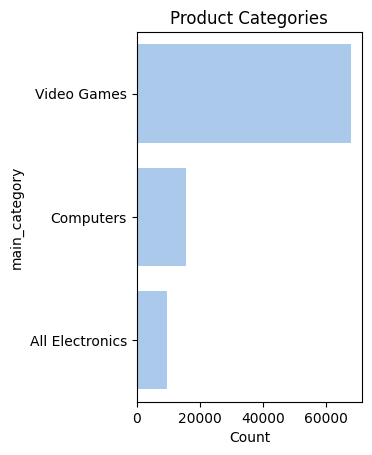

In [ ]:

# Set the color palette
sns.set_palette('pastel')

# Create multiple visualizations
# plt.figure(figsize=(10, 30))

# Plotting a bar chart of product categories
plt.subplot(1, 2, 1)
sns.countplot(data=merged_df, y='main_category')
plt.title('Product Categories')
plt.xlabel('Count')

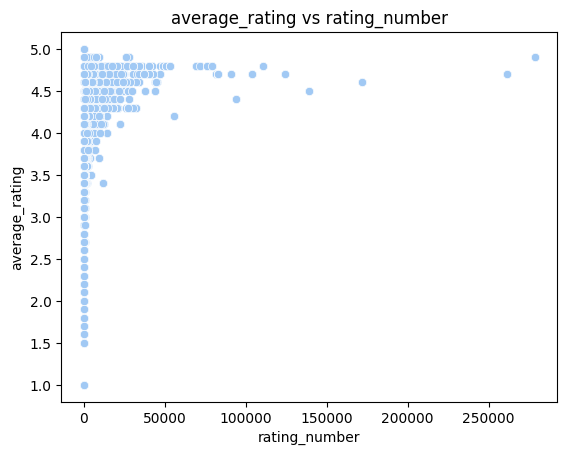

In [72]:
# plt.figure(figsize=(10, 8))
sns.scatterplot(x='rating_number', y='average_rating', data=merged_df)
plt.title('average_rating vs rating_number')
plt.show()

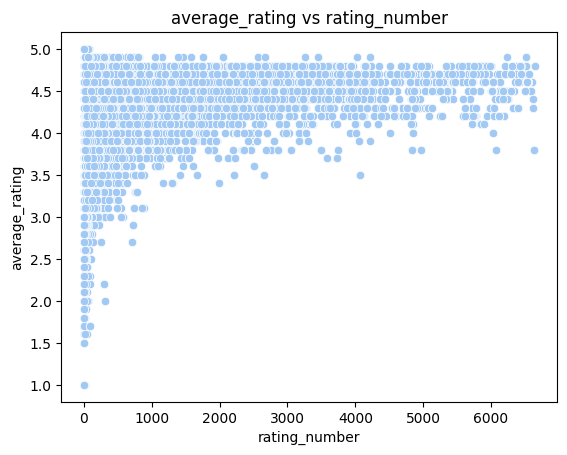

In [150]:
# plt.figure(figsize=(10, 8))
sns.scatterplot(x='rating_number', y='average_rating', data=merged_df)
plt.title('average_rating vs rating_number')
plt.show()

In [179]:
merged_df_weight.columns

Index(['rating', 'title_x', 'text', 'parent_asin', 'user_id', 'main_category',
       'title_y', 'features', 'description', 'categories', 'weighted_rating'],
      dtype='object')

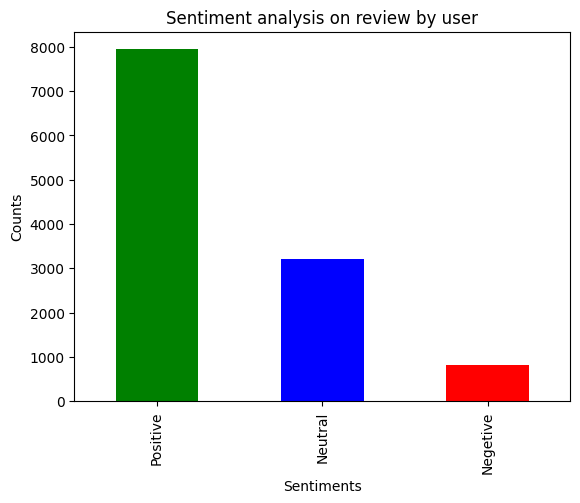

In [181]:
from textblob import TextBlob

# Classify Sentiment 
def senti_als(text):
    analysis = TextBlob(text)
    # threshold for positive & negetive polarity
    if analysis.sentiment.polarity > 0.1:
        return 'Positive'
    elif analysis.sentiment.polarity < -0.1:
        return 'Negetive'
    else:
        return 'Neutral'
    
    
# apply sentiment analysis on review_content

sentimen = merged_df_weight['text'].apply(senti_als)
sentiment_count = sentimen.value_counts()

# plot the bar 
sentiment_count.plot(kind='bar',color=['green','blue','red'],title="Sentiment analysis on review by user")
plt.xlabel('Sentiments')
plt.ylabel('Counts')
plt.show()

## Content Based Filtering

In [15]:
selected_columns = ['user_id','parent_asin','main_category','title_y','features','description']
content_df = merged_df_weight[selected_columns]

In [16]:
content_df['item_description'] = content_df['main_category'] + " " + content_df['title_y'] + " " + content_df['features'] + " " + content_df['description']

/var/folders/cn/7s_wm3ld3vlgcgkl1g9n5vs40000gn/T/ipykernel_35853/700916753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df['item_description'] = content_df['main_category'] + " " + content_df['title_y'] + " " + content_df['features'] + " " + content_df['description']


In [17]:
content_df.shape

(475265, 7)

In [21]:
content_df = content_df.drop_duplicates(subset=['parent_asin'], keep='first')
content_df.shape

(11584, 7)

In [22]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.5, stop_words='english')
# tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 1),min_df=0.5, stop_words='english')
tfidf_matrix = tf.fit_transform(content_df['item_description'])

In [29]:
# cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

content_df = content_df.reset_index()
titles = content_df['parent_asin']
indices = pd.Series(content_df.index, index=content_df['parent_asin'])



In [246]:
# np.save('cosine_scores.npy', cosine_sim)
loaded_scores = np.load('cosine_scores.npy')

In [247]:
def get_recommendations(title):
    idx = indices[title]
    idx = idx
    # sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = list(enumerate(loaded_scores[idx]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    product_indices = [i[0] for i in sim_scores]
    products = content_df.iloc[product_indices][['title_y', 'parent_asin']]
    # return titles.iloc[product_indices]
    return products

In [25]:
content_df.head()

,index,user_id,parent_asin,main_category,title_y,features,description,item_description
0,0,151286,4954,Video Games,Cyberpunk 2077 - PC [Game Download Code in Box],Become a cyberpunk an urban mercenary equipped...,"Cyberpunk 2077 is an open world, an action adv...",Video Games Cyberpunk 2077 - PC [Game Download...
1,10,142502,555,Video Games,Gioteck PS3 Dual L / R Triggers Controller Att...,Outfit all your Sony Controllers and gain a co...,The aim of the Real Triggers attachments are t...,Video Games Gioteck PS3 Dual L / R Triggers Co...
2,11,142502,10826,All Electronics,"Younik Vertical Stand for PS-4 Slim, Built-in ...",Specially designed for PS-4 Slim Console Allow...,,All Electronics Younik Vertical Stand for PS-4...
3,13,57867,10656,All Electronics,"AMVR Controller Grips for Quest 2, Controller ...",Controller Grips for Quest 2 -- AMVR design th...,,All Electronics AMVR Controller Grips for Ques...
4,16,57867,9066,All Electronics,Seltureone Accessories Compatible for Quest 2 ...,Compatibility: Designed specially for Quest 2 ...,,All Electronics Seltureone Accessories Compati...


In [248]:
get_recommendations(4954).head()

,title_y,parent_asin
134,LucidSound LS30 - Wireless Universal Gaming He...,3071
297,Doom - PC,7132
349,ASTRO Gaming A50 Wireless Headset + Base Stati...,10827
756,Borderlands Ultimate Edition - PS3 [Digital Code],634
786,Endless Ocean: Blue World - Nintendo Wii,777


In [33]:
list(content_df[content_df['parent_asin'] == 4954]['title_y'])[0]

'Cyberpunk 2077 - PC [Game Download Code in Box]'

In [37]:
list(content_df[content_df['parent_asin'] == 777]['title_y'])[0]

'Endless Ocean: Blue World - Nintendo Wii'

## Collaborative Filter

#### Round 1

In [103]:
merged_df_weight.head(3)

,rating,title_x,text,parent_asin,user_id,main_category,title_y,features,description,categories,weighted_rating
0,4,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,4306,43044,Video Games,Cyberpunk 2077 - PC [Game Download Code in Box],Become a cyberpunk an urban mercenary equipped...,"Cyberpunk 2077 is an open world, an action adv...",Video Games PC Games,4.122629
10,4,good,"good, a tad bit too bulky, but good. they stay...",486,40545,Video Games,Gioteck PS3 Dual L / R Triggers Controller Att...,Outfit all your Sony Controllers and gain a co...,The aim of the Real Triggers attachments are t...,,3.991833
11,1,It does not fasten itself to the bottom of the...,just another cheap knock-off. It does not fast...,9297,40545,All Electronics,"Younik Vertical Stand for PS-4 Slim, Built-in ...",Specially designed for PS-4 Slim Console Allow...,,Video Games Legacy Systems Sega Systems Sega S...,4.566797


In [46]:
reader = Reader(rating_scale=(1, 5))

colab_data = Dataset.load_from_df(merged_df_weight[['user_id', 'parent_asin', 'rating']], reader)
# Split dataset into train and test sets
trainset, testset = train_test_split(colab_data, test_size=0.2, random_state=42)

# Train SVD model
algo = SVD()
algo.fit(trainset)

# Make predictions for test set
predictions = algo.test(testset)

# Evaluate predictions
accuracy.rmse(predictions)
# Print a few example predictions
for prediction in predictions[:5]:
    print('User:', prediction.uid)
    print('Item:', prediction.iid)
    print('Actual Rating:', prediction.r_ui)
    print('Predicted Rating:', prediction.est)
    print()
# cross_validate(svd, colab_data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

RMSE: 1.1989
User: 7733
Item: 1180
Actual Rating: 3.0
Predicted Rating: 4.215525961602968

User: 9412
Item: 6456
Actual Rating: 5.0
Predicted Rating: 5

User: 11435
Item: 6955
Actual Rating: 5.0
Predicted Rating: 4.251176436683016

User: 18422
Item: 8101
Actual Rating: 5.0
Predicted Rating: 4.350324733672709

User: 18518
Item: 3765
Actual Rating: 5.0
Predicted Rating: 4.261657624822385



In [29]:
# Run cross-validation to evaluate the model
results = cross_validate(algo, colab_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print results
print("Mean RMSE:", results['test_rmse'].mean())
print("Mean MAE:", results['test_mae'].mean())

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2220  1.2228  1.2249  1.2183  1.1875  1.2151  0.0140  
MAE (testset)     0.9248  0.9280  0.9252  0.9263  0.9011  0.9211  0.0100  
Fit time          0.14    0.13    0.13    0.13    0.13    0.13    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Mean RMSE: 1.215087861816564
Mean MAE: 0.9210776287641483


In [37]:
algo.predict('AF5PEAYOVNBEP75IQOHG6KJKPEGA', 'B07YBWT3PK', 3)

Prediction(uid='AF5PEAYOVNBEP75IQOHG6KJKPEGA', iid='B07YBWT3PK', r_ui=3, est=4.130590970190148, details={'was_impossible': False})

#### Round 2

In [108]:
min_rating = 5

user_rating_counts = merged_df_weight.groupby('user_id').size()
users_more_than_one = user_rating_counts[user_rating_counts >= min_rating]
print(f"users with more than {min_rating} ratings", len(users_more_than_one))

# Filtering the dataframe based with the requirement
user_counts = merged_df_weight['user_id'].value_counts()
colab_filter_df = merged_df_weight[merged_df_weight['user_id'].isin(user_counts[user_counts >= min_rating].index)]
colab_filter_df = colab_filter_df.drop_duplicates(keep='first')

users with more than 5 ratings 13968


In [161]:
min_rating = 5

item_rating_counts = colab_filter_df.groupby('parent_asin').size()
items_more_than_one = item_rating_counts[item_rating_counts >= min_rating]
print(f"items with more than {min_rating} ratings", len(items_more_than_one))

# # Filtering the dataframe based with the requirement
# item_counts = merged_df_weight['parent_asin'].value_counts()
# colab_filter_df = merged_df_weight[merged_df_weight['parent_asin'].isin(user_counts[user_counts >= min_rating].index)]
# colab_filter_df = colab_filter_df.drop_duplicates(keep='first')

items with more than 5 ratings 4576


In [109]:
colab_filter_df.head(3)

,rating,title_x,text,parent_asin,user_id,main_category,title_y,features,description,categories,weighted_rating
145,1,Does not fit GameCube as described.,Terrible. Gave as a Christmas gift. It says ...,5227,214405,Computers,AreMe AC Power Supply Adapter and AV Cable for...,Compatible with Wii. The power cords provide t...,Compatible with Wii. The power cords provide t...,Video Games Legacy Systems Nintendo Systems Wi...,4.408704
146,4,This works great!,Love the lighted background. It works well Th...,4935,214405,Computers,Razer Huntsman Elite Gaming Keyboard: Fast Key...,Faster Than Legacy Mechanical Switches: Razer ...,Introduces the new Razer Opto-Mechanical switc...,Video Games PC Accessories Gaming Keyboards,4.673938
149,1,They didn't stay on the joystick very well.,We didnt like these. They didn't stay well on...,4809,214405,Video Games,Amazon Basics PlayStation 4 Controller Thumb G...,,Product Description Amazon Basics PlayStation ...,,4.225728


In [ ]:
reader = Reader(rating_scale=(1, 5))

colab_data = Dataset.load_from_df(colab_filter_df[['user_id', 'parent_asin', 'rating']], reader)
# Split dataset into train and test sets
trainset, testset = train_test_split(colab_data, test_size=0.2, random_state=42)

# Train SVD
algo = SVD(n_factors=100)
algo.fit(trainset)

# Predict ratings
predictions = algo.test(testset)

# Calculate RMSE
rmse = accuracy.rmse(predictions)
print(f"Initial RMSE: {rmse}")

param_grid = {
    "n_factors": [25, 40, 55],  # default 100
    "n_epochs": [10, 20],  # default 20
    "lr_all": [0.005, 0.025, 0.125],  # learning rate for all parameters. Default 0.005
    "reg_all": [0.08, 0.16, 0.32],  # regularization term for all parameters. Default 0.02
    "random_state": [0],
}

grid_search = GridSearchCV(
    SVD,
    param_grid,
    measures=["rmse", "mae"],
    cv=3,  # 5,
    refit=True,
    n_jobs=-1,
    joblib_verbose=2
)

grid_search.fit(colab_data)

pd.DataFrame.from_dict(grid_search.cv_results)[[
    "mean_test_rmse", "mean_test_mae", "param_n_factors",
    "param_n_epochs", "param_lr_all", "param_reg_all"
]].sort_values("mean_test_rmse")


RMSE: 1.0361
Initial RMSE: 1.0361209268604354


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   15.0s finished


,mean_test_rmse,mean_test_mae,param_n_factors,param_n_epochs,param_lr_all,param_reg_all
41,1.034690,0.743029,55,10,0.025,0.32
5,1.034766,0.741778,25,10,0.025,0.32
4,1.034846,0.734088,25,10,0.025,0.16
23,1.034905,0.742552,40,10,0.025,0.32
40,1.035124,0.736459,55,10,0.025,0.16
22,1.035197,0.735429,40,10,0.025,0.16
3,1.036931,0.731295,25,10,0.025,0.08
50,1.037254,0.732386,55,20,0.025,0.32
21,1.037835,0.733504,40,10,0.025,0.08
32,1.038238,0.732144,40,20,0.025,0.32


In [171]:
best_model = grid_search.best_estimator["rmse"]

In [149]:
# Get all user IDs in the training set
train_users = [trainset.to_raw_uid(inner_id) for inner_id in trainset.all_users()]
print("Users in training set:", train_users)
# Get all item IDs in the training set
train_items = [trainset.to_raw_iid(inner_id) for inner_id in trainset.all_items()]
print("Items in training set:", train_items)

Users in training set: [36262, 95637, 261607, 111050, 95952, 22, 40375, 100687, 30041, 220962, 112368, 3584, 191744, 120218, 233492, 133039, 105629, 202646, 135269, 4221, 112823, 81519, 83733, 192046, 59508, 18297, 70881, 241387, 190503, 87953, 27422, 88291, 217739, 241365, 153301, 184544, 87015, 19212, 35754, 133201, 50554, 21305, 82465, 76444, 192635, 40706, 171628, 24248, 133409, 250130, 215851, 22645, 171861, 12033, 19284, 192225, 143038, 167702, 179606, 114868, 30271, 40916, 168830, 219780, 267012, 225461, 41813, 23261, 65060, 97940, 241217, 131317, 211853, 229457, 136399, 139500, 251340, 117412, 179661, 173282, 262854, 8493, 202929, 63593, 257337, 201543, 21280, 139187, 28158, 161725, 185414, 2050, 108766, 29942, 207750, 103999, 105328, 221904, 90287, 147730, 38369, 189331, 115904, 139502, 43073, 198558, 253770, 178013, 79499, 159189, 25105, 134355, 129512, 136393, 222974, 122331, 144540, 12948, 126886, 195658, 208136, 226952, 892, 151806, 201939, 219278, 105622, 159375, 82178, 1

In [193]:
best_model.predict(uid=167885, iid=5227)

Prediction(uid=167885, iid=5227, r_ui=None, est=3.710370524381907, details={'was_impossible': False})

In [250]:
from surprise import dump
file_path = "svd_model_a.pkl"
dump.dump(file_path,algo=best_model)

In [251]:
_, loaded_svd_model = dump.load(file_path)
loaded_svd_model.predict(uid=167885, iid=5227)

Prediction(uid=167885, iid=5227, r_ui=None, est=3.710370524381907, details={'was_impossible': False})

## Hybrid Approach

In [232]:
# Input - User ID and Product ID
# Output - Recommendations

def get_hybrid_recommendations(user_id, parent_asin):
    """
    Using both 
    """
    idx = indices[parent_asin]
    idx = idx
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    product_indices = [i[0] for i in sim_scores]
    products = content_df.iloc[product_indices][['title_y', 'parent_asin']]
    products['estimate'] = 0
    # estimate_list = []
    for index, row in products.iterrows():
        product = row['parent_asin']
        # user = row['user_id']
        estimate = best_model.predict(uid=user_id, iid=product).est
        # estimate_list.append(estimate)
        products.at[index, 'estimate'] = estimate
    # print(estimate_list)
        # products.at[index, 'estimate'] = estimate
    products = products.sort_values('estimate', ascending=False)
    # return titles.iloc[product_indices]
    return products.head(10)

In [229]:
best_model.predict(24278, 174)

Prediction(uid=24278, iid=174, r_ui=None, est=4.042962068627945, details={'was_impossible': False})

In [233]:
get_hybrid_recommendations(167885, 2204)

/var/folders/cn/7s_wm3ld3vlgcgkl1g9n5vs40000gn/T/ipykernel_35853/2369071765.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.544939435848865' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  products.at[index, 'estimate'] = estimate


,title_y,parent_asin,estimate
894,Batman: Arkham City - Game of The Year Edition...,6918,4.648644
167,Talkworks Joy Con Charging Dock for Nintendo S...,10161,4.569160
57,Razer Kaira X Wired Headset for Xbox Series X|...,11432,4.544939
666,TALK WORKS Nintendo Switch Screen Protector - ...,7699,4.540619
427,Sony PlayStation Dualsense Wireless Controller...,8513,4.526512
402,Just Dance 4,1508,4.523665
642,"STOGA Controller for Nintendo Switch, Panda Sw...",10180,4.500691
318,Just Dance 2016 - PlayStation 4,2617,4.445049
721,Turtle Beach Recon 200 Gen 2 Powered Gaming He...,7481,4.422732
109,Nintendo DS Lite AC Adapter,380,4.395795


In [234]:
get_hybrid_recommendations(233167, 2204)

/var/folders/cn/7s_wm3ld3vlgcgkl1g9n5vs40000gn/T/ipykernel_35853/2369071765.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.647497866466036' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  products.at[index, 'estimate'] = estimate


,title_y,parent_asin,estimate
894,Batman: Arkham City - Game of The Year Edition...,6918,4.750398
167,Talkworks Joy Con Charging Dock for Nintendo S...,10161,4.668747
57,Razer Kaira X Wired Headset for Xbox Series X|...,11432,4.647498
666,TALK WORKS Nintendo Switch Screen Protector - ...,7699,4.642850
427,Sony PlayStation Dualsense Wireless Controller...,8513,4.625242
402,Just Dance 4,1508,4.623647
642,"STOGA Controller for Nintendo Switch, Panda Sw...",10180,4.596387
318,Just Dance 2016 - PlayStation 4,2617,4.544811
721,Turtle Beach Recon 200 Gen 2 Powered Gaming He...,7481,4.520775
426,PS5 Digital Edition- Horizon Forbidden West Bu...,10786,4.493155


In [235]:
get_recommendations(2204).head(10)

57     11432
63      7082
109      380
112     9536
113     5963
167    10161
300    10536
318     2617
402     1508
426    10786
Name: parent_asin, dtype: int64